In [1]:
import os, sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("E:\git\python3\StereoSiTE")
from stereosite import scii_tensor
from stereosite.plot import sankey, scii_circos, scii_net
from stereosite.plot import scii_tensor as scii_tensor_plot

## Visualization of core matrix
Draw the sankey plot and the 3D heatmap to visualize the core matrix.

In [2]:
#load core matrix
with open(".\data\core.pickle", 'rb') as reader:
    core = pickle.load(reader)
#normalize the core matrix
norm_core = scii_tensor.core_normalization(core, feature_range=(0, 100))

In [3]:
#process core matrix to generate dataFrame that will be used to draw sankey plot.
left_df, right_df = sankey.core_process(norm_core)

E:\git\python3\StereoSiTE\stereosite\plot\sankey.py:197: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(data_l[(data_l.left.isnull()) | (data_r.right.isnull()) | (data_l.mid_l.isnull()) | (data_r.mid_r.isnull())]):


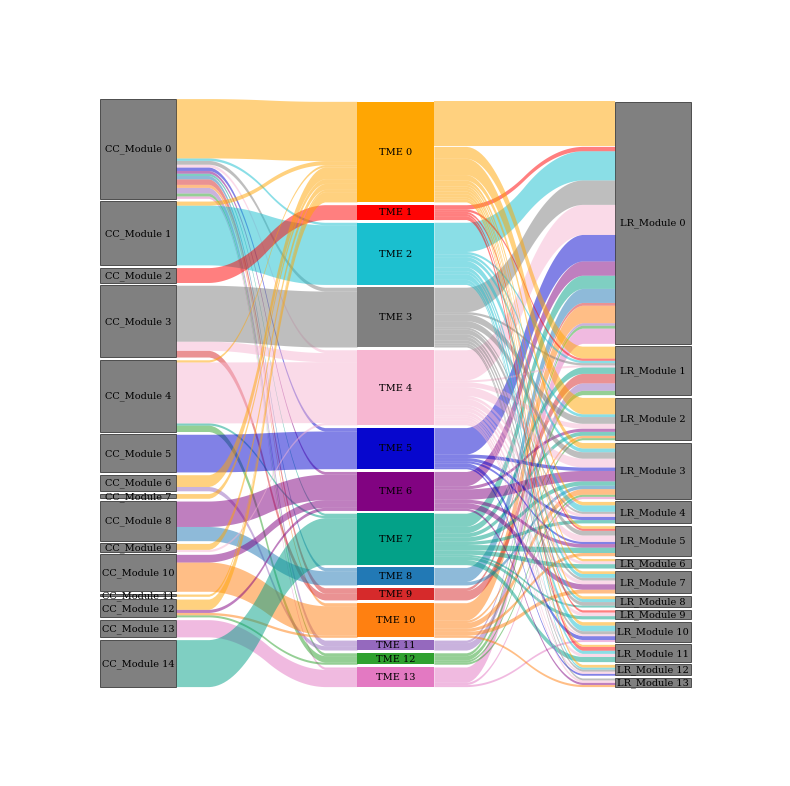

In [4]:

#draw sankey plot
color_map = {'TME 0': '#FFA500',
                'TME 1': '#FF0000',
                'TME 2': '#17BECF',
                'TME 3': '#7F7F7F',
                'TME 4': '#F7B6D2',
                'TME 5': '#0404CE',
                'TME 6': '#800080',
                'TME 7': '#00A087',
                'TME 8': '#1F77B4',
                'TME 9': '#D62728',
                'TME 10': '#FF7F0E',
                'TME 11': '#9467BD',
                'TME 12': '#2CA02C',
                'TME 13': '#E377C2',
                'TME 14': '#BCBD22',
                }
for cc_module in left_df.left.unique():
    color_map[cc_module] = '#7F7F7F'
for lr_module in  right_df.right.unique():
    color_map[lr_module] = '#7F7F7F'
cc_labels = []
lr_labels = []
for i in range(15):
    cc_labels.append(f"CC_Module {i}")
    if i==14:
        continue
    lr_labels.append(f"LR_Module {i}")

sankey.sankey_3d(left_df, right_df, 
                 left_labels=cc_labels[::-1], right_labels=lr_labels[::-1],
                 cmap=color_map, link_alpha=0.5, interval=0.005, 
                 save="./scii_tensor/sankey_3d.png")

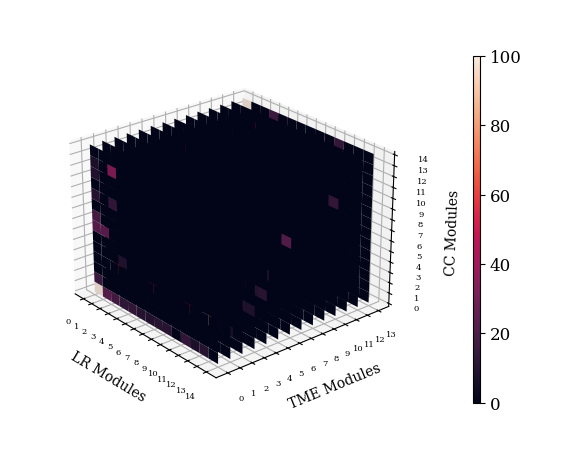

In [35]:
scii_tensor_plot.core_heatmap(norm_core, save="./scii_tensor/core_3d_heatmap.png")

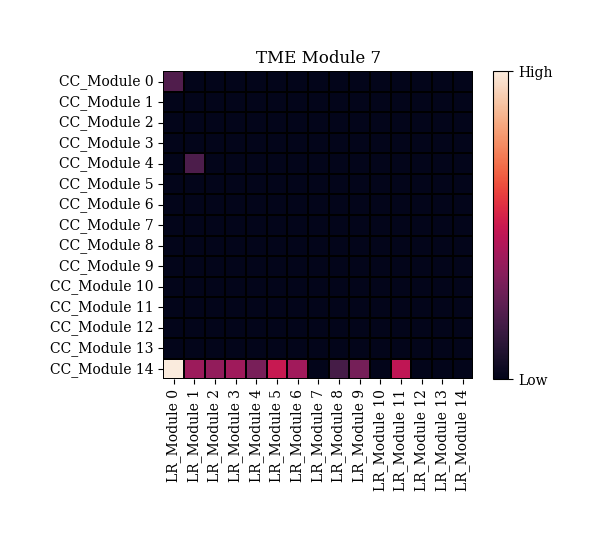

In [36]:
scii_tensor_plot.tme_core_heatmap(norm_core, tme_number=7)

## Heatmap of factor matrices
Draw heatmap plots to visualize factor matrices, including cell-cell module matrix and ligand-receptor module matrix.

In [5]:
#load factor matrices of cell-cell module, ligand-receptor module, and tme module
#load all scii_tensor matrix of every window/bin
with open("./data/factors.pickle", 'rb') as reader:
    factors = pickle.load(reader)
scii_tensor_file = "./data/lr_mt_list_filter.pickle"
with open(scii_tensor_file, 'rb') as reader:
    scii_matrices = pickle.load(reader)

In [6]:
#process factor matrices to generate dataframe
import pandas as pd
cc_index = scii_matrices[0].index
lr_index = scii_matrices[0].columns
factor_cc = pd.DataFrame(factors[0], index=cc_index)
factor_cc.columns = factor_cc.columns.map(lambda x: f"CC_Module {x}")
factor_lr = pd.DataFrame(factors[1], index=lr_index)
factor_lr.columns = factor_lr.columns.map(lambda x: f"LR_Module {x}")
factor_tme = pd.DataFrame(factors[2])
factor_tme.columns = factor_tme.columns.map(lambda x: f"TME {x}")

In [7]:
gene_list_file = "./data/filter_genes.xlsx"
gene_list_df = pd.read_excel(gene_list_file)
gene_list = gene_list_df['Gene Symbol'].values.tolist()
factor_lr = factor_lr[[all([x not in gene_list for x in y.split("_")]) for y in factor_lr.index]]

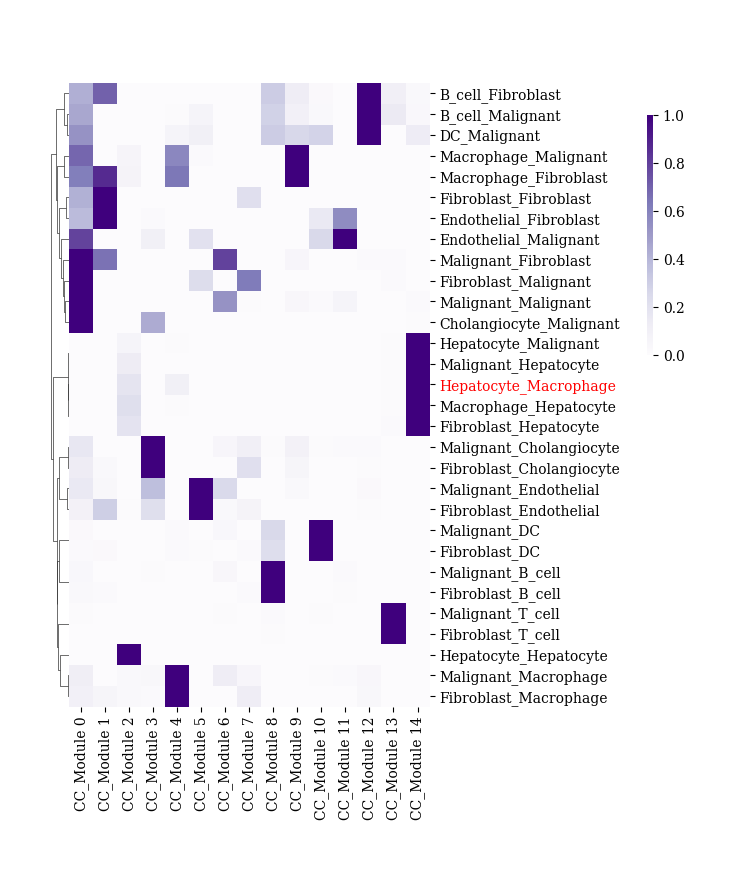

In [8]:
#draw the heatmap based on the cell-cell factor matrix
factor_cc_top = factor_cc.loc[factor_cc.sum(axis=1).sort_values(ascending=False).index[0:30]]
fig = sns.clustermap(factor_cc_top, cmap="Purples", standard_scale=0, metric='euclidean', method='ward', 
                     col_cluster=False, dendrogram_ratio=0.05, cbar_pos=(1.02, 0.6, 0.01, 0.3),
                     figsize=(6, 8),
                     )
tick_labels = fig.ax_heatmap.get_yticklabels()
highlight_pairs = ['Hepatocyte_Macrophage']
for tick_label in tick_labels:
    if tick_label.get_text() in highlight_pairs:
        tick_label.set_color('red')
fig.savefig("./scii_tensor/factor_cc_heatmap.pdf")

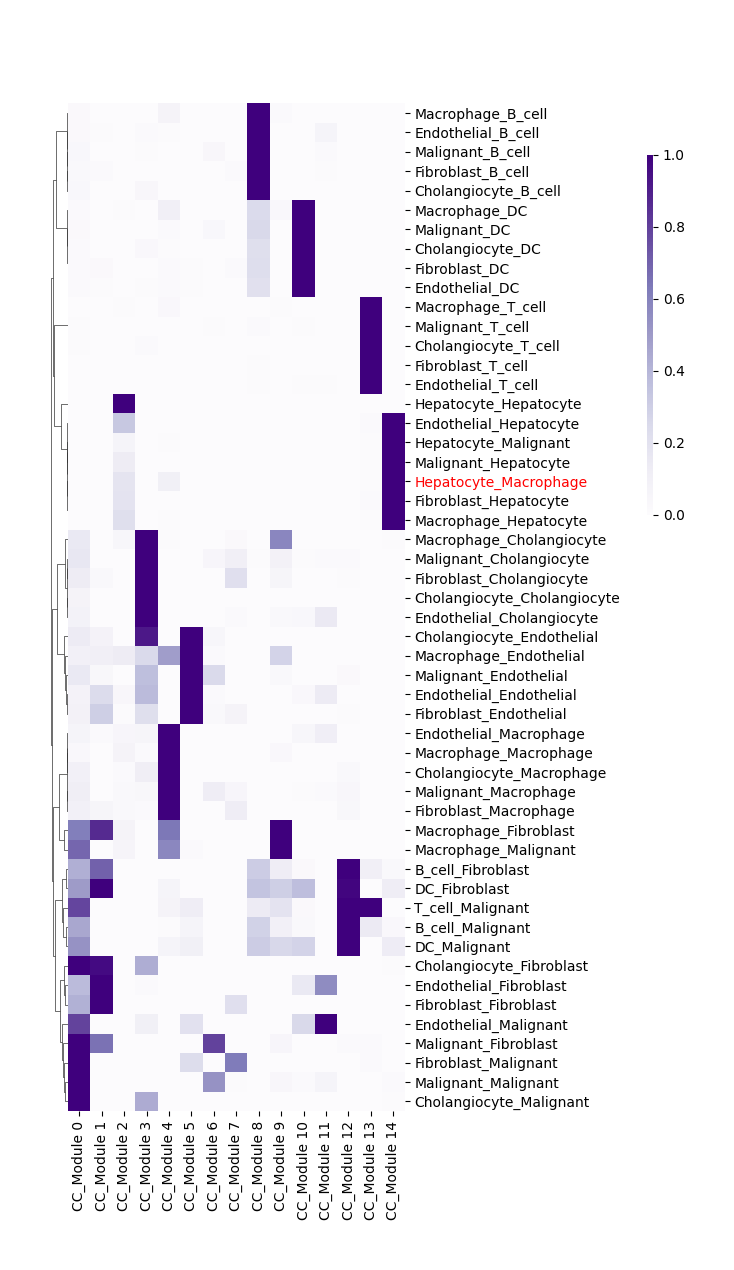

In [12]:
def _sorted(s, num):
        tmp = s.sort_values(ascending=False)[:num].index  # earlier s.order(..)
        tmp.index = range(num)
        return tmp
top_cc_pairs = set()
for module in factor_cc.columns:
    top_cc_pairs = top_cc_pairs | set(_sorted(factor_cc[module], 5).tolist())
factor_cc_top = factor_cc.loc[list(top_cc_pairs)]
fig = sns.clustermap(factor_cc_top, cmap='Purples', standard_scale=0, metric='euclidean', method='ward', 
                     cbar_pos=(1.02, 0.6, 0.01, 0.3), figsize=(6, 12),
                     col_cluster=False, dendrogram_ratio=0.05,
                    )
tick_labels = fig.ax_heatmap.get_yticklabels()
highlight_pairs = ['Hepatocyte_Macrophage']
for tick_label in tick_labels:
    if tick_label.get_text() in highlight_pairs:
        tick_label.set_color('red')

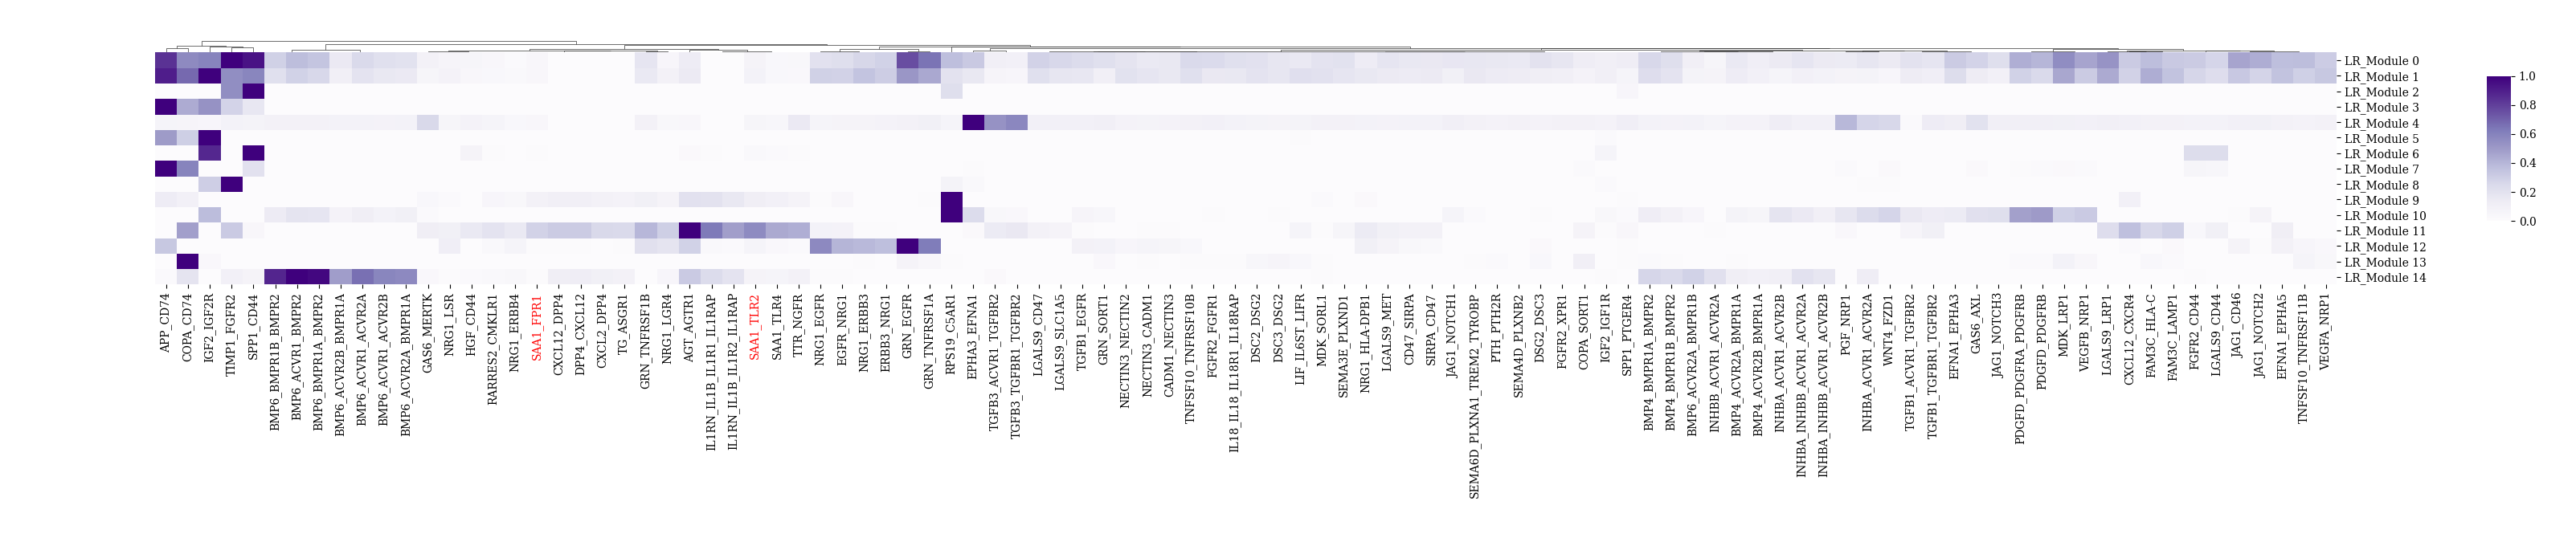

In [16]:
#select the top ligand-receptor pairs, then draw the heatmap based on ligan-receptor factor matrix
lr_number = 100 #number of ligand-receptor pairs on the top that will remain
factor_lr_top = factor_lr.loc[factor_lr.sum(axis=1).sort_values(ascending=False).index[0:lr_number]]
fig = sns.clustermap(factor_lr_top.T, cmap="Purples", standard_scale=0, metric='euclidean', method='ward', 
                     row_cluster=False, dendrogram_ratio=0.05, cbar_pos=(1.02, 0.6, 0.01, 0.3),
                     figsize=(30, 6),
                     )
tick_labels = fig.ax_heatmap.get_xticklabels()
highlight_pairs = ['SAA1_TLR2', 'SAA1_FPR1']
for tick_label in tick_labels:
    if tick_label.get_text() in highlight_pairs:
        tick_label.set_color('red')
fig.savefig("./scii_tensor/factor_lr_heatmap.pdf")

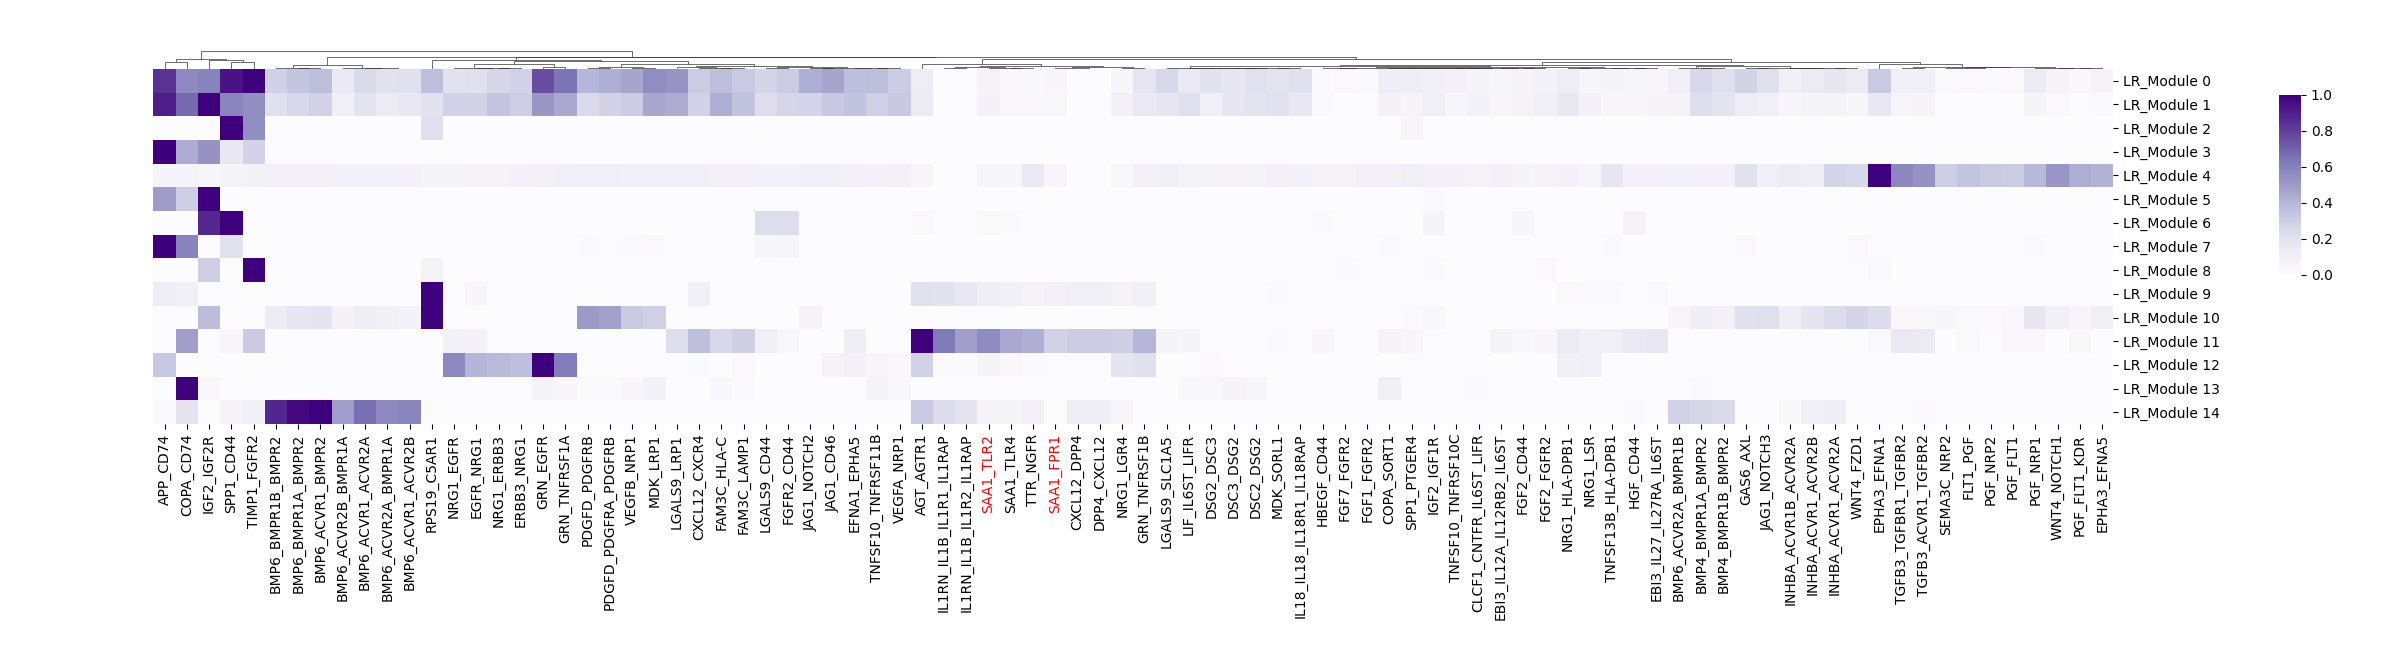

In [13]:
top_lr_pairs = set()
for module in factor_lr.columns:
    top_lr_pairs = top_lr_pairs | set(_sorted(factor_lr[module], 12).tolist())
factor_lr_top = factor_lr.loc[list(top_lr_pairs)]
fig = sns.clustermap(factor_lr_top.T, cmap='Purples', standard_scale=0, metric='euclidean', method='ward', 
                     cbar_pos=(1.02, 0.6, 0.01, 0.3), figsize=(22, 6),
                     row_cluster=False, dendrogram_ratio=0.05,
                    )
tick_labels = fig.ax_heatmap.get_xticklabels()
highlight_pairs = ['SAA1_TLR2', 'SAA1_FPR1']
for tick_label in tick_labels:
    if tick_label.get_text() in highlight_pairs:
        tick_label.set_color('red')

## Interaction selection
Select interactions in the TME region of interest. Only the top cell-cell pairs of a specific cell-cell module and the top ligand-receptor pairs of a specific ligand-receptor module remain.

In [9]:
interaction_matrix = scii_circos.scii_tensor_select(scii_matrices, factor_cc, factor_lr, factor_tme, 
                               interest_TME='TME 7',
                               interest_cc_module='CC_Module 14',
                               interest_LR_module='LR_Module 11',
                               lr_number=20,
                               cc_number=10)

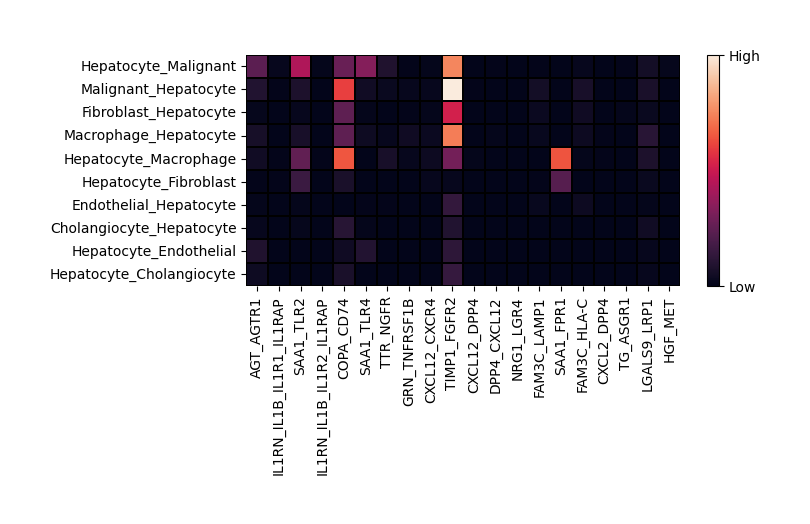

In [8]:
from stereosite.plot.scii_tensor import interaction_heatmap
interaction_heatmap(interaction_matrix, figsize=(7, 3), vmax=40)

## Circos
Draw the circos plot to visualize the selected interaction matrix.

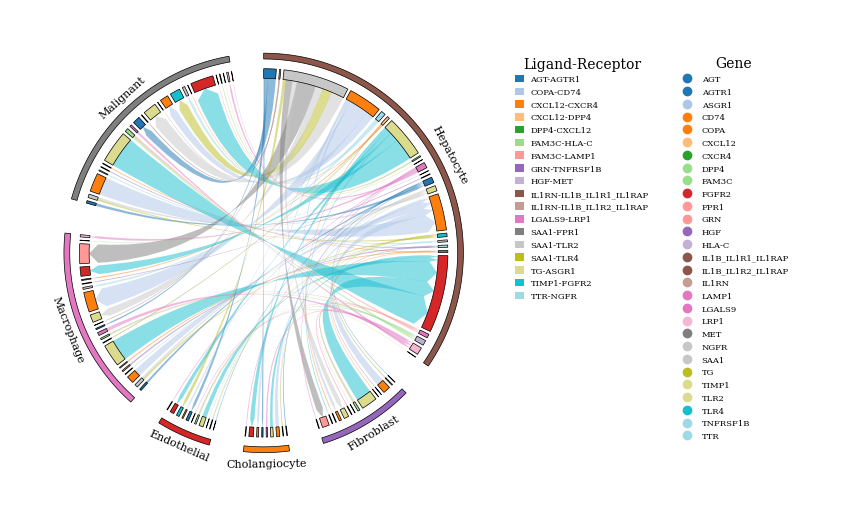

In [10]:
#Draw the circos diagram, which includes cell types, ligand-receptor genes, and the links between ligands and receptors.
cells = ['Hepatocyte', 'Fibroblast', 'Cholangiocyte', 'Endothelial', 'Macrophage', 'Malignant', 'B_cell', 'T_cell', 'DC', 'NK'] #list contains names of all cell types
cell_colors = {'B_cell': '#1f77b4',
                'Cholangiocyte': '#ff7f0e',
                'DC': '#2ca02c',
                'Endothelial': '#d62728',
                'Fibroblast': '#9467bd',
                'Hepatocyte': '#8c564b',
                'Macrophage': '#e377c2',
                'Malignant': '#7f7f7f',
                'NK': '#bcbd22',
                'T_cell': '#17becf'}
scii_circos.cells_lr_circos(interaction_matrix, cells=cells, cell_colors=cell_colors,  scii_tensor=True, separater="_", save="./scii_tensor/cells_lr_circos.pdf")

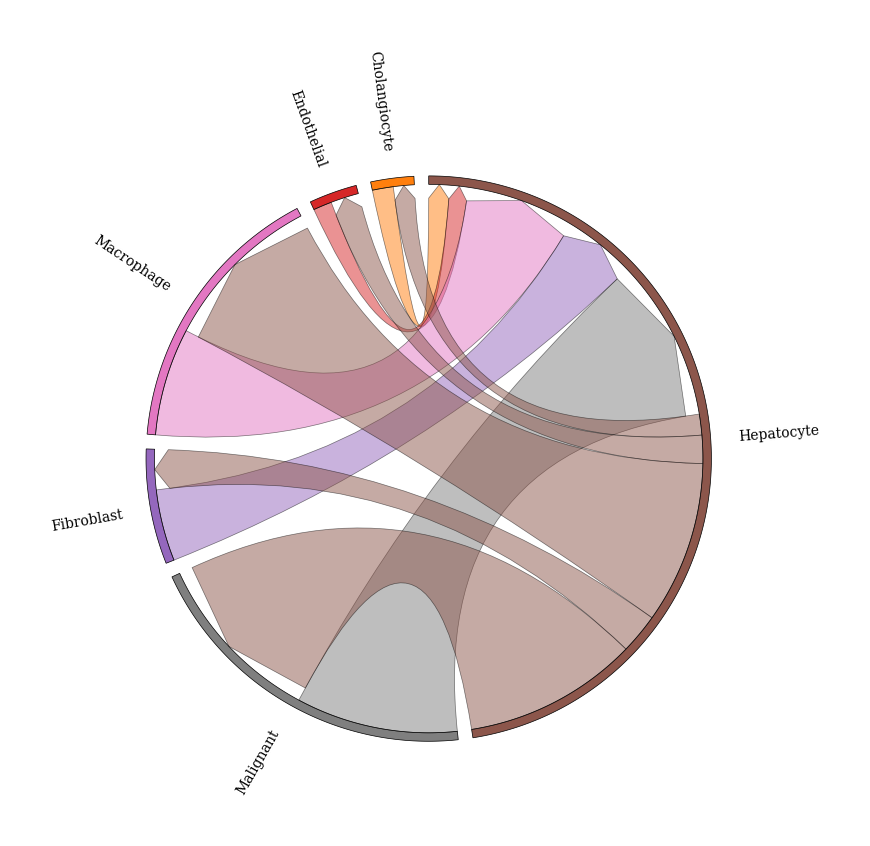

In [12]:
#Draw the circos which only contains cell types and the links between them.
scii_circos.cells_circos(interaction_matrix, cells, cell_colors=cell_colors, label_orientation='vertical', scii_tensor=True, save="./scii_tensor/cells_circos.pdf")

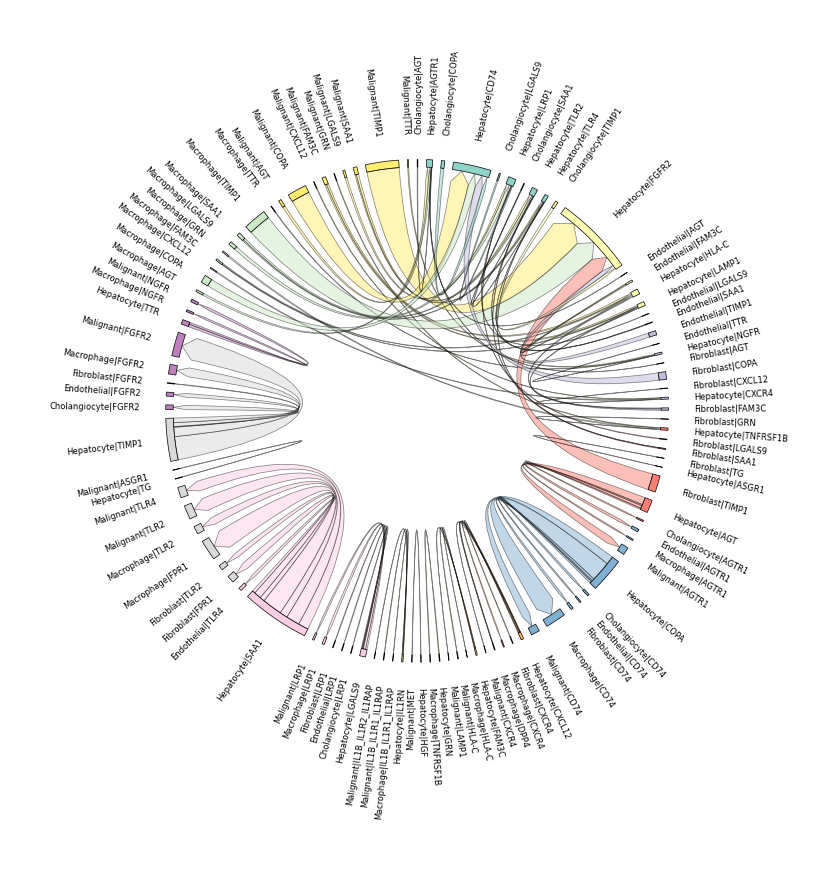

In [11]:
#Draw circos which only contains ligand-receptor genes
scii_circos.lr_circos(interaction_matrix, cells=cells, separator="_", scii_tensor=True)

## Igraph
Draw a network diagram to visualize the interaction matrix.

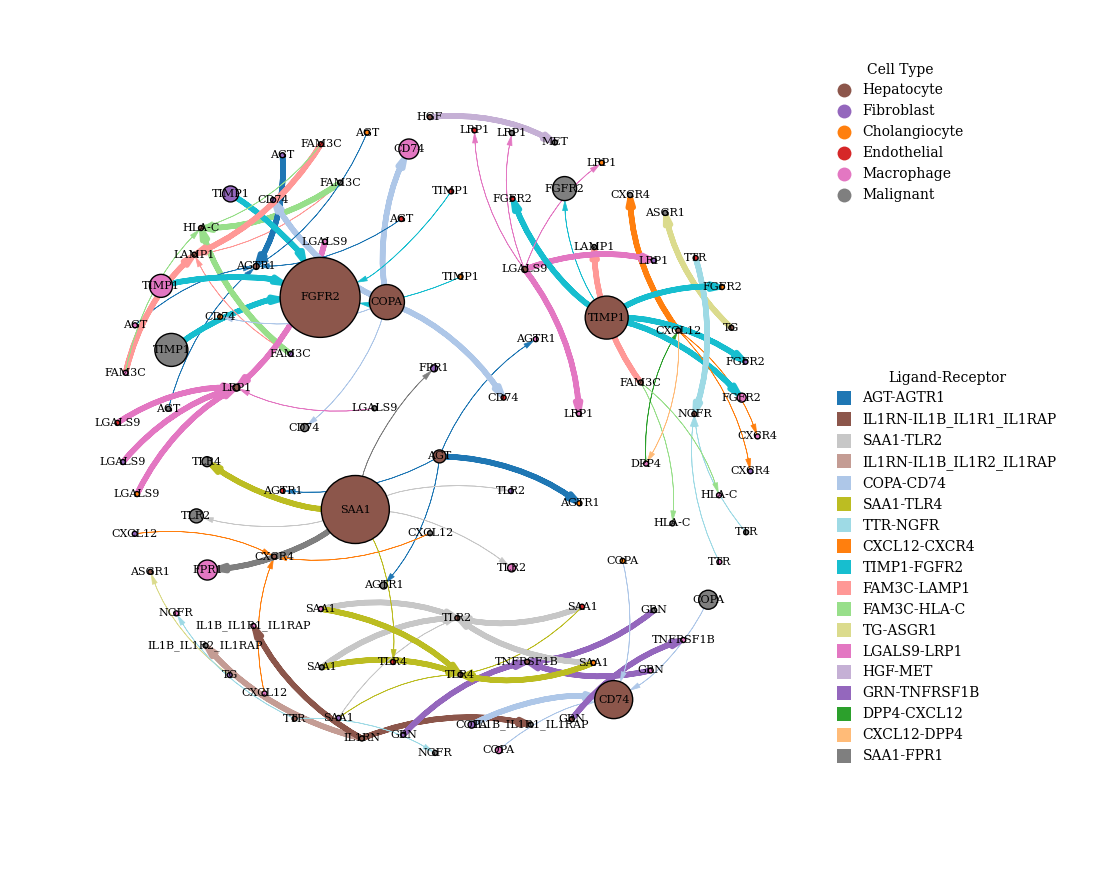

In [11]:
#Draw the network diagram based on the Graph generated previously.
from stereosite.plot.scii_net import lr_link_graph_generate
g1 = lr_link_graph_generate(interaction_matrix, cells = cells, separator="_", cell_colors=cell_colors, scii_tensor=True)
scii_net.cell_lr_graph_plot(g1, figsize=10,
                   save="./scii_tensor/igrap_network.pdf")

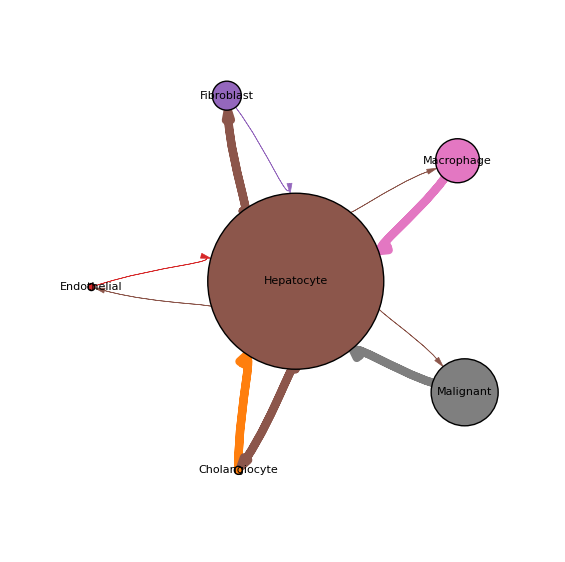

In [17]:
from stereosite.plot.scii_net import cell_graph_generate
g2 = cell_graph_generate(interaction_matrix, cells = cells, cell_colors=cell_colors, reducer=3, scii_tensor=True)
scii_net.cell_graph_plot(g2, figsize=6, edge_width=[0.5, 6])

# SCII Visualization

In [2]:
interaction_file = "./data/interaction_min.pkl"
with open(interaction_file, 'rb') as reader:
    scii_dict = pickle.load(reader)

In [3]:
from stereosite.scii import interaction_select, interaction_pathway_select
import pandas as pd
cells = ['Epithelial', 'Macrophages', 'DC', 'B', 'Mast', 'CD8+', 'CD4+', 'CAF', 'NK']
cell_pairs = []
for sender in cells:
    for receiver in cells:
        if sender != receiver:
            cell_pairs.append((sender, receiver))
gene_list_file = "./data/filter_genes.xlsx"
gene_list_df = pd.read_excel(gene_list_file)
gene_list = gene_list_df['Gene Symbol'].values.tolist()

In [4]:
filter_interaction = interaction_select(scii_dict, cell_pairs=cell_pairs, filter_genes=gene_list, intensities_range=(6000, 8000))

E:\git\python3\StereoSiTE\stereosite\plot\scii.py:371: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
c:\Users\liuxing2\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\liuxing2\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


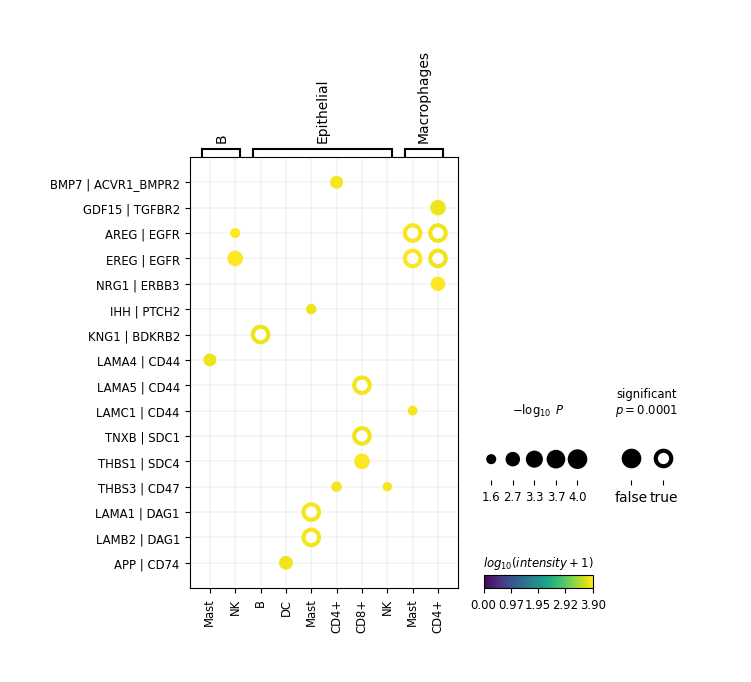

In [5]:
from stereosite.plot.scii import ligrec
ligrec(filter_interaction,
       pvalue_threshold=0.05,
       alpha=1e-4,
       swap_axes=False,
       source_groups = ['Epithelial', 'Macrophages', 'B'],
       target_groups = ['B', 'DC', 'Mast', 'CD4+', 'CD8+', 'NK'],
       title="",
       )

In [6]:
pathway_names = ['EGF']
interactiondb_file = "../stereosite/datasets/LR_database/CellChatDB.human.csv"
pathway_interaction = interaction_pathway_select(scii_dict, pathway_name=pathway_names, interactiondb_file=interactiondb_file)

E:\git\python3\StereoSiTE\stereosite\plot\scii.py:371: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
c:\Users\liuxing2\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\liuxing2\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


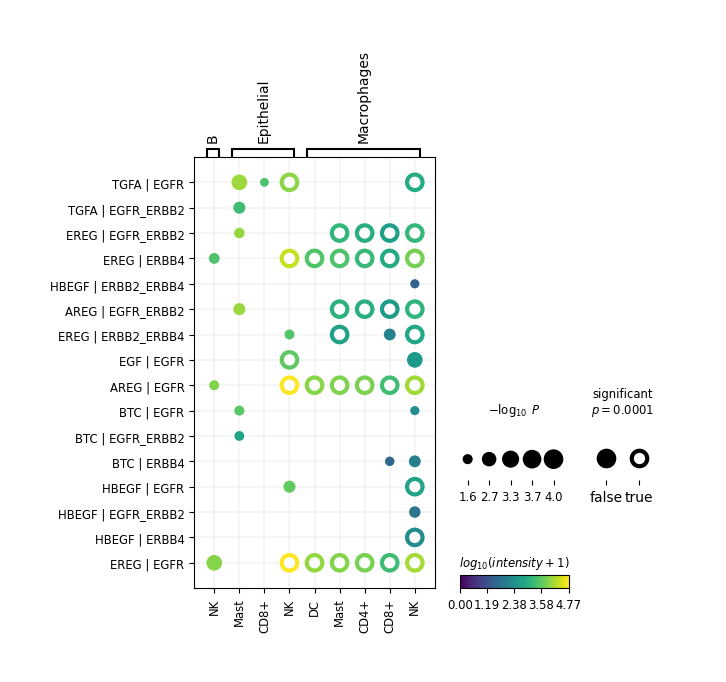

In [7]:
ligrec(pathway_interaction,
       pvalue_threshold=0.05,
       alpha=1e-4,
       swap_axes=False,
       source_groups = ['Epithelial', 'Macrophages', 'B'],
       target_groups = ['B', 'DC', 'Mast', 'CD4+', 'CD8+', 'NK'],
       title="",
       )

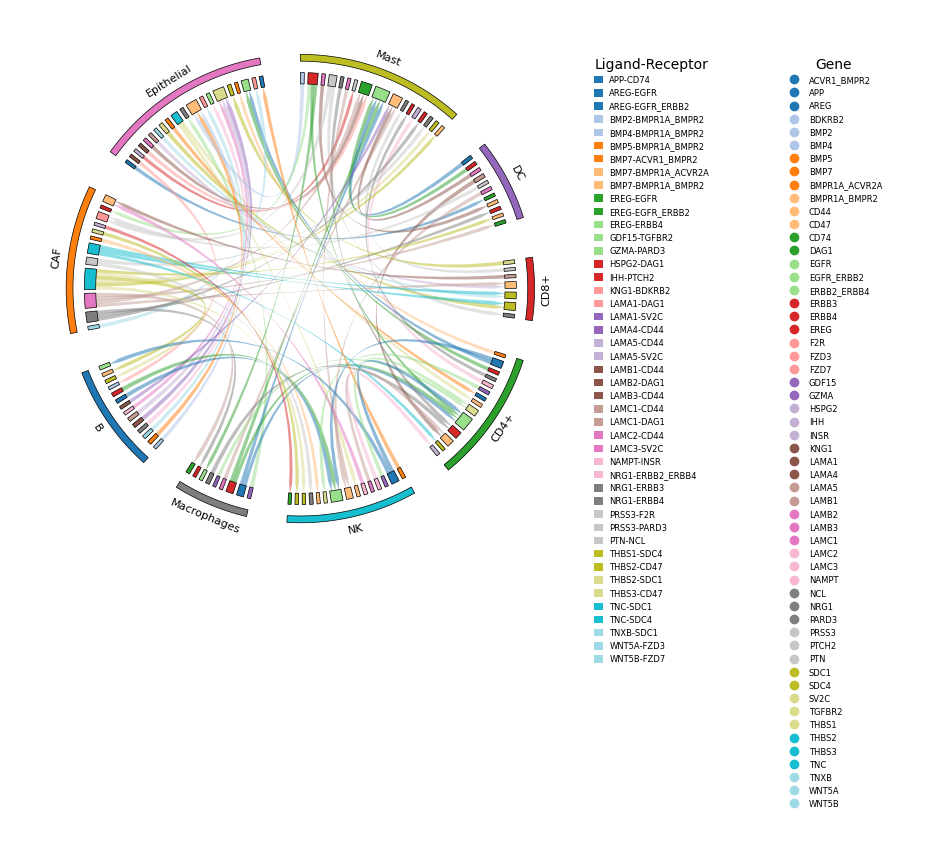

In [8]:
filter_matrix = filter_interaction['intensities'].fillna(0)
cell_colors = {'B': '#1f77b4',
                'CAF': '#ff7f0e',
                'CD4+': '#2ca02c',
                'CD8+': '#d62728',
                'DC': '#9467bd',
                'Endothelial': '#8c564b',
                'Epithelial': '#e377c2',
                'Macrophages': '#7f7f7f',
                'Mast': '#bcbd22',
                'NK': '#17becf'}
scii_circos.cells_lr_circos(filter_matrix, cell_colors=cell_colors)

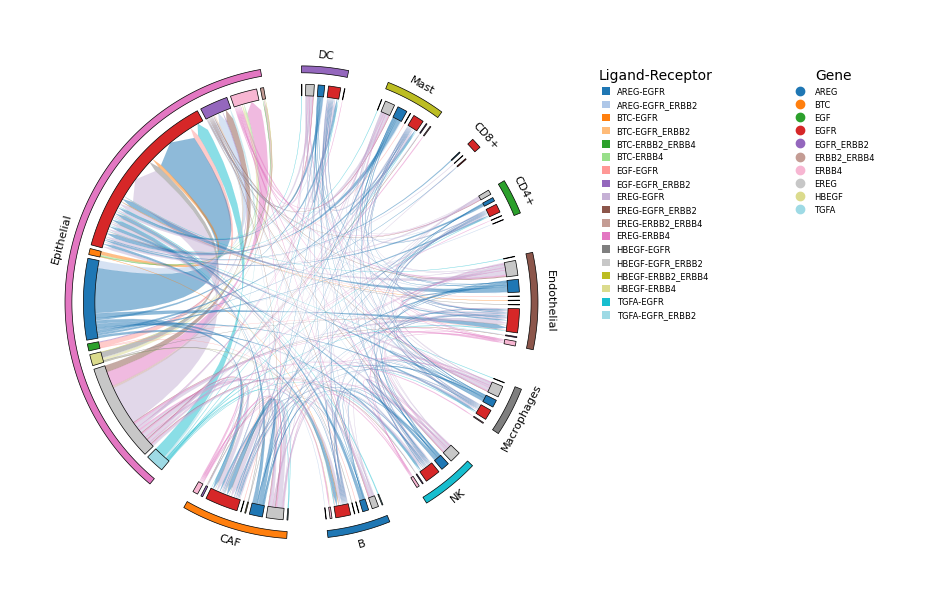

In [9]:
pathway_matrix = pathway_interaction['intensities'].fillna(0)
scii_circos.cells_lr_circos(pathway_matrix, cell_colors=cell_colors)

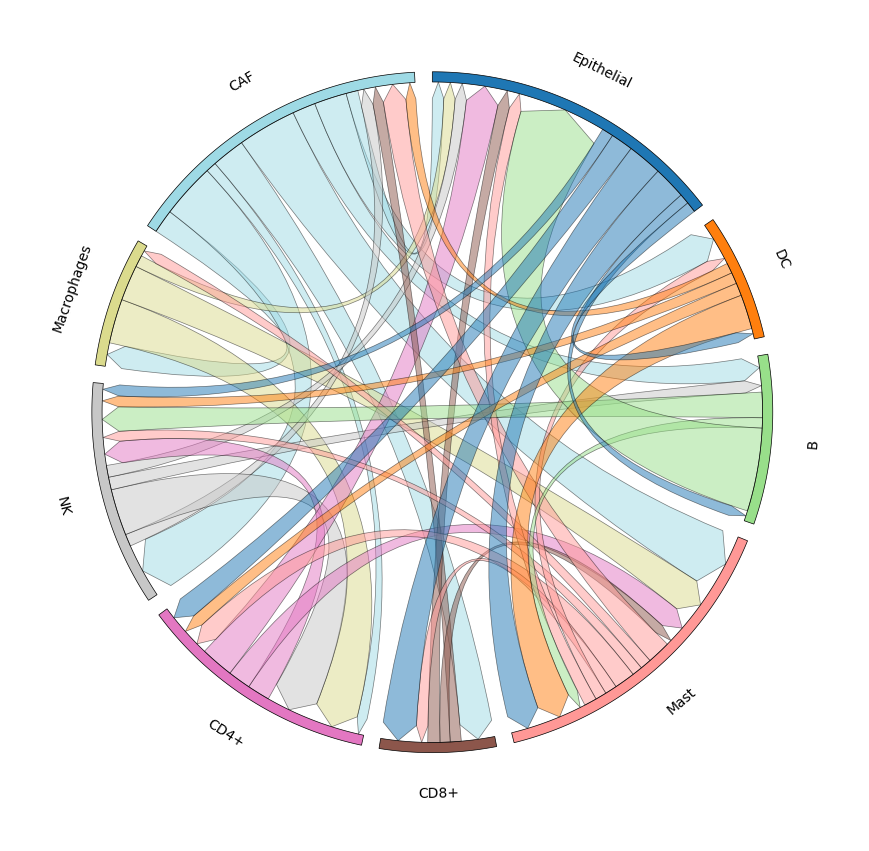

In [10]:
scii_circos.cells_circos(filter_matrix)

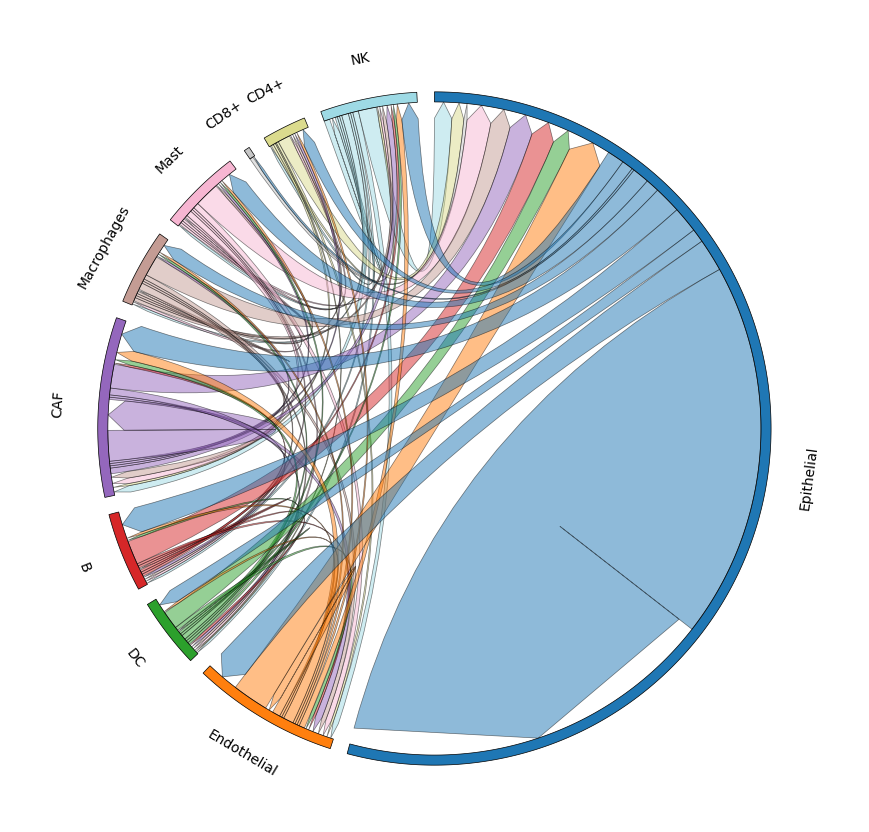

In [11]:
scii_circos.cells_circos(pathway_matrix)

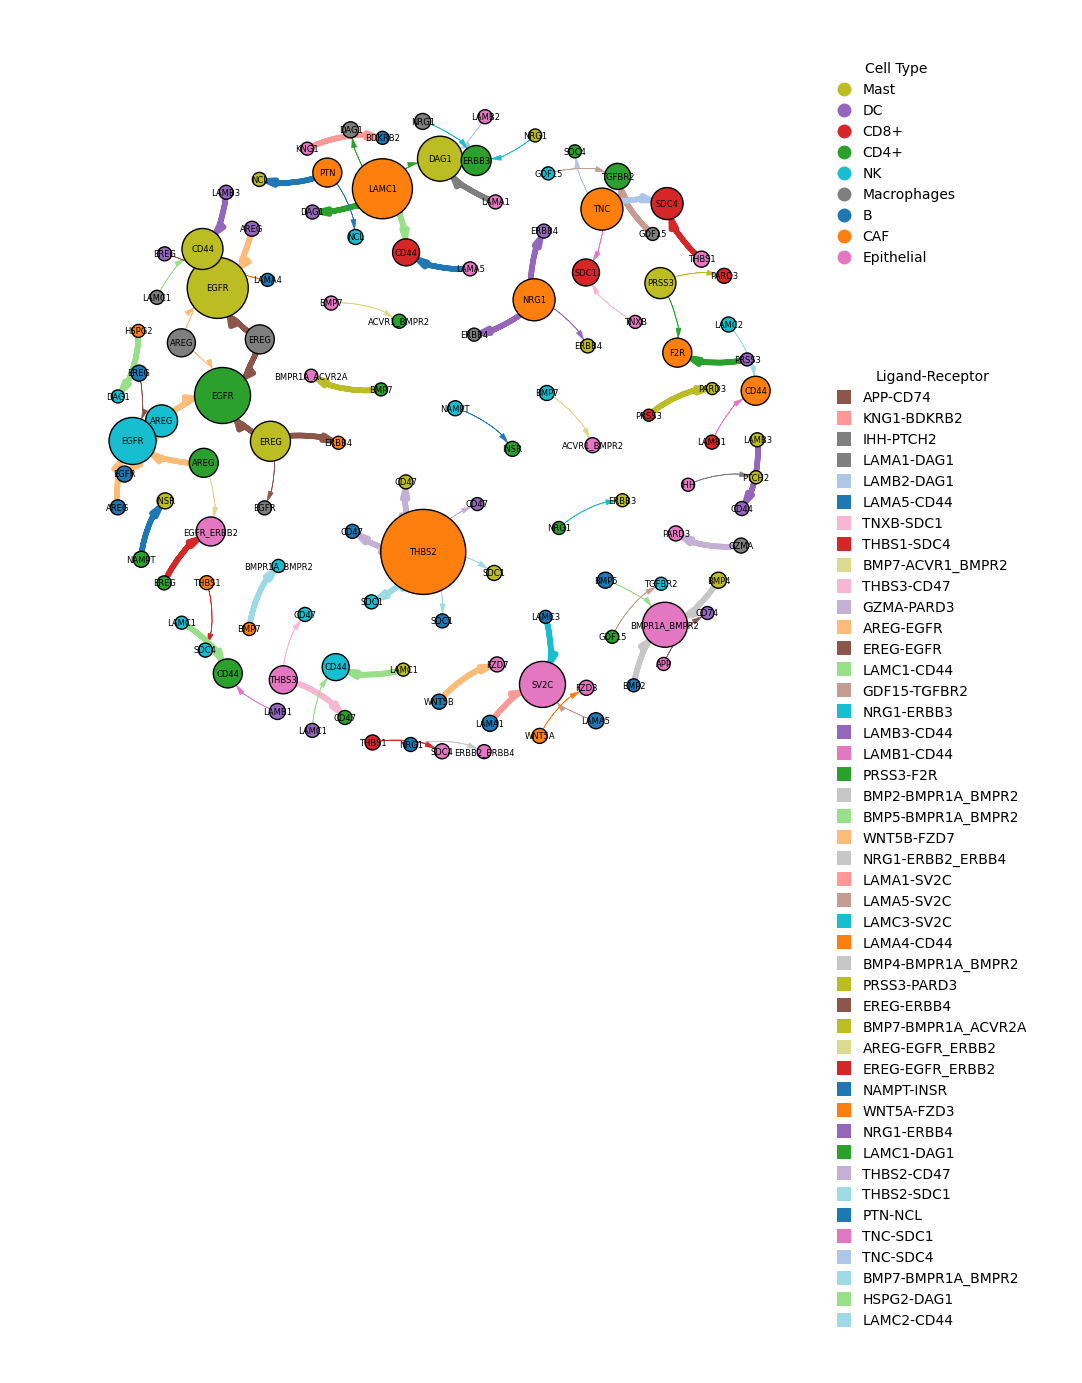

In [14]:
#Draw the network diagram based on the Graph generated previously.
from stereosite.plot.scii_net import lr_link_graph_generate, cell_graph_generate
g1 = lr_link_graph_generate(filter_matrix, cell_colors=cell_colors, reducer=6)
scii_net.cell_lr_grap_plot(g1, figsize=10, vertex_label_size=6)

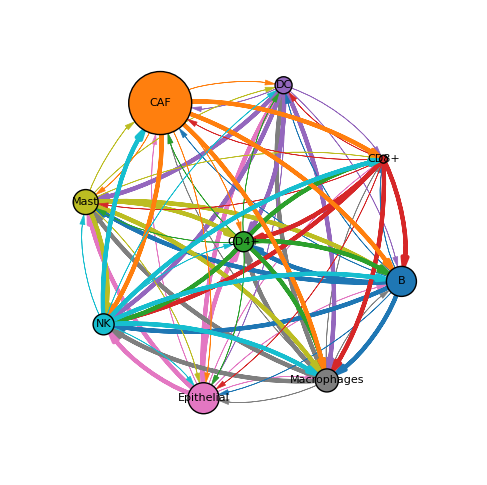

In [25]:
g2 = cell_graph_generate(filter_matrix, reducer=30, cell_colors=cell_colors)
scii_net.cell_graph_plot(g2, vertex_label_size=8, figsize=5, edge_width=[0.5, 3])

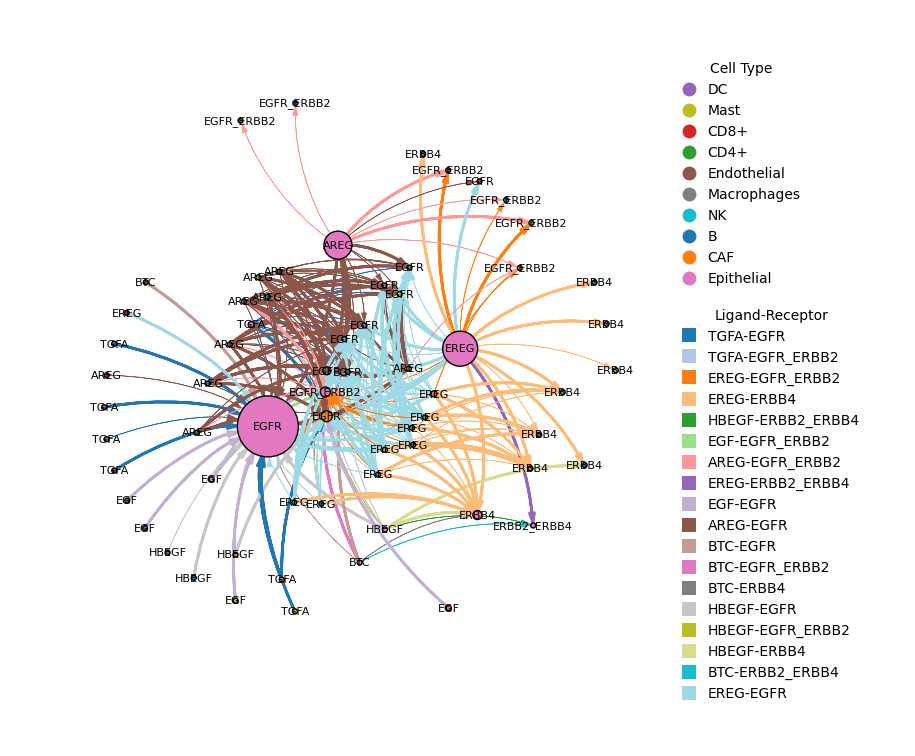

In [29]:
g3 = lr_link_graph_generate(pathway_matrix, cell_colors=cell_colors, reducer=6)
scii_net.cell_lr_grap_plot(g3, figsize=8, edge_width=[0.5, 2])

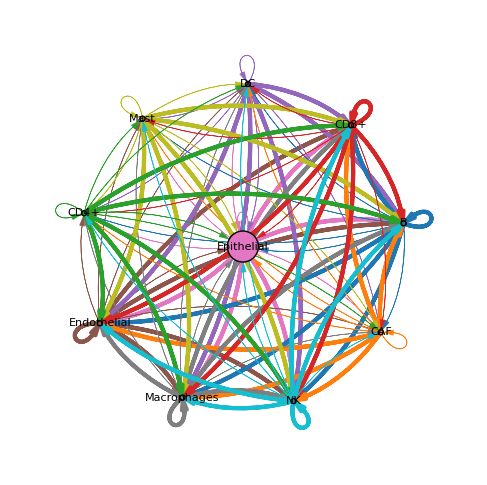

In [31]:
g4 = cell_graph_generate(pathway_matrix, reducer=15, cell_colors=cell_colors)
scii_net.cell_graph_plot(g4, vertex_label_size=8, figsize=5, edge_width=[0.5, 3])

In [6]:
from stereosite.plot import sankey
components = 5
interactiondb_file = "../stereosite/datasets/LR_database/CellChatDB.human.csv"
sankey_df_W_s, sankey_df_H_s = sankey.interaction_matrix_decomposition(filter_matrix, interactiondb_file=interactiondb_file, components=components, cell_level=0)
sankey_df_W_r, sankey_df_H_r = sankey.interaction_matrix_decomposition(filter_matrix, interactiondb_file=interactiondb_file, components=components, cell_level=1)

In [9]:
import matplotlib.pyplot as plt
colors_dict = cell_colors
pattern_colors = plt.get_cmap("Set2", components).colors
pattern_labels = []
for i in range(components):
    pattern_label = f"Pattern {i+1}"
    colors_dict[pattern_label] = pattern_colors[i]
    pattern_labels.append(pattern_label)
pathway_color = (0.4980392156862745, 0.4980392156862745, 0.4980392156862745) #gray
for pathway_name in set(sankey_df_H_s['right'].unique())&set(sankey_df_H_r['right'].unique()):
    colors_dict[pathway_name] = pathway_color
pattern_labels = pattern_labels[::-1]

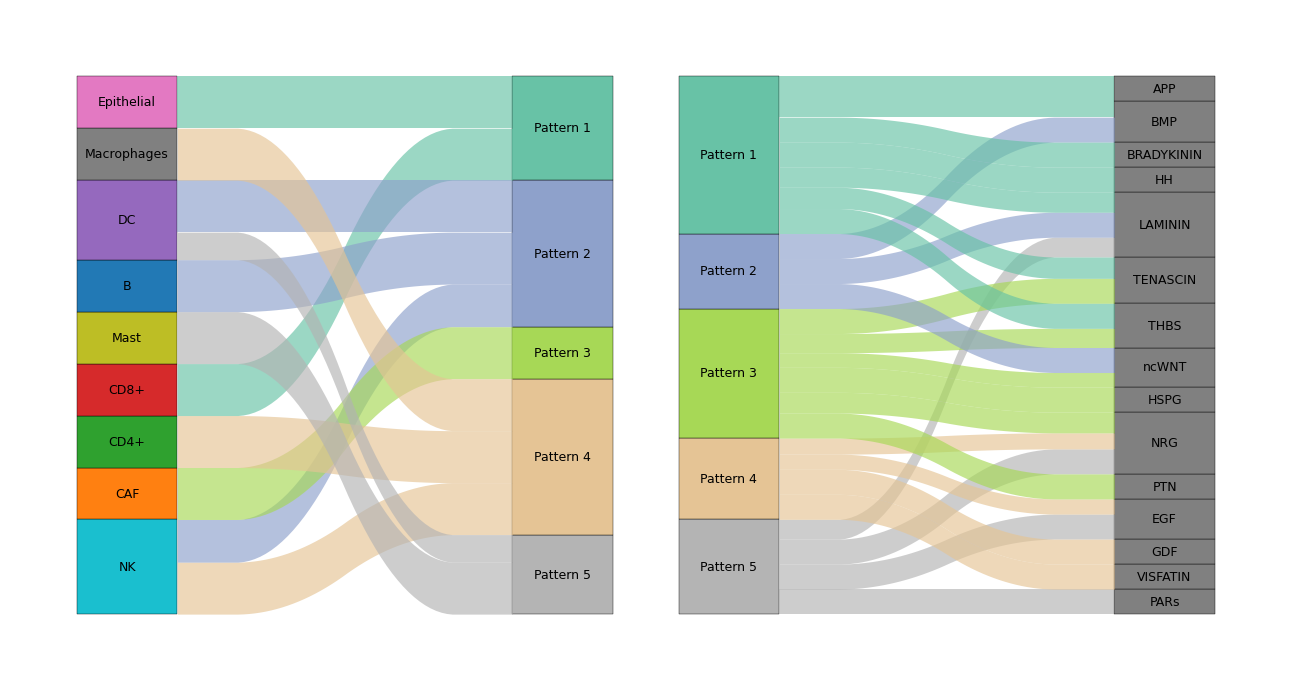

In [11]:
sankey.sankey_pathway_decomposition(sankey_df_W_s, sankey_df_H_s, cmap=colors_dict, mid_labels=pattern_labels)

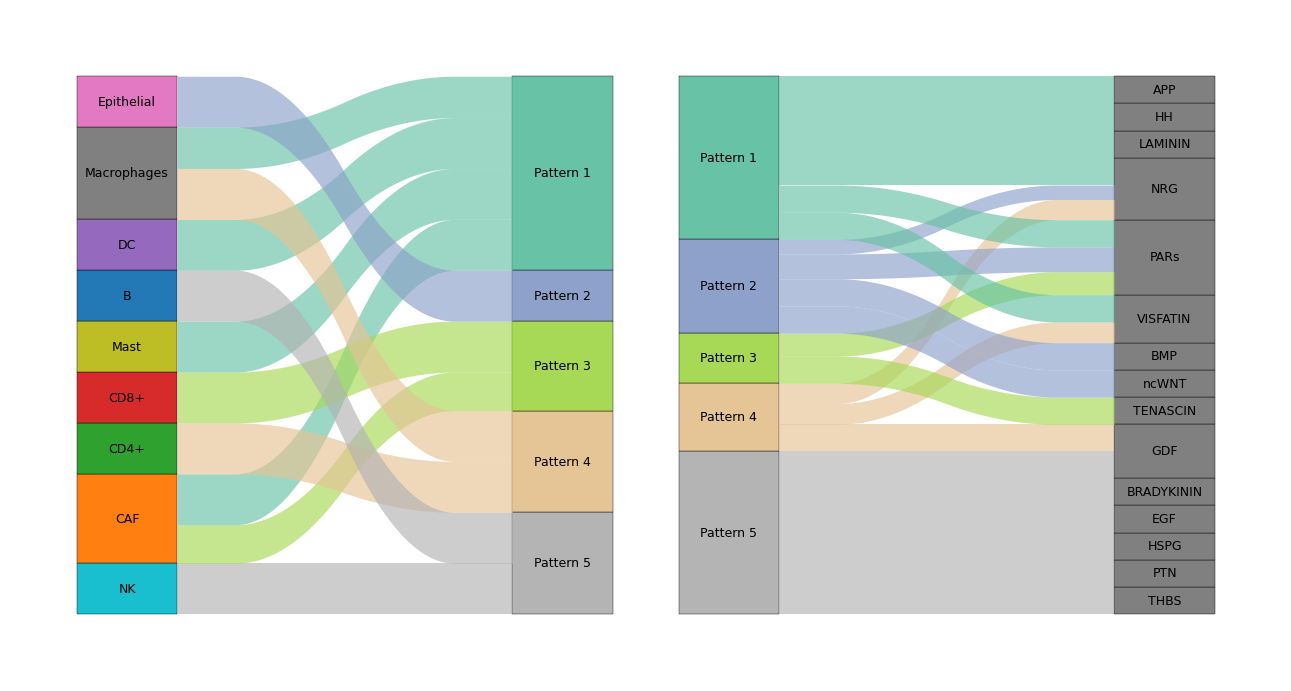

In [12]:
sankey.sankey_pathway_decomposition(sankey_df_W_r, sankey_df_H_r, cmap=colors_dict, mid_labels=pattern_labels)